<a href="https://colab.research.google.com/github/shininglight99/ellison-archive/blob/master/10Year_US_treasury_Note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install QuantLib-Python 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests
from bs4 import BeautifulSoup
import QuantLib as ql

In [2]:
def GET_DATE():
  req = requests.get("https://www.marketwatch.com/investing/bond/tmubmusd10y?countrycode=bx")
  html = req.text
  soup = BeautifulSoup(html, 'html.parser')
  data = soup.find("span", class_="WSJBase--card__timestamp--2xDXNOQK")
  date = data.text
  date = datetime.datetime.strptime(date, "%m/%d/%y").date()
  return date

            discount factor  zero rate
maturity                              
2021-03-02         0.936808   1.220926
2021-05-06         0.801469   1.132757
2021-08-05         0.668971   0.999641
2022-01-27         0.510440   0.823251
2023-01-31         0.992164   0.003965
2024-01-15         0.985061   0.005122
2026-01-31         0.983975   0.003243
2028-01-31         0.983669   0.002358


AttributeError: ignored

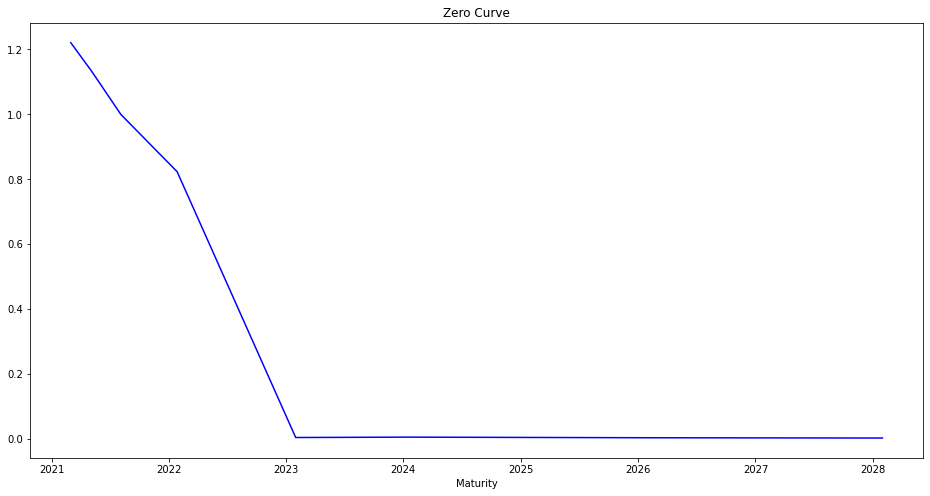

In [21]:
import re
import requests
from datetime import datetime
import pandas as pd

def GET_QUOTE(reference_date):
    if not isinstance(reference_date, datetime):
        reference_date = datetime.strptime(reference_date, "%Y-%m-%d")
    maturity = ["01m", "03m", "06m", "01y", "02y", "03y", "05y", "07y", "10y", "30y"]
    bond_table = pd.DataFrame(columns = ["maturity", "days", "price", "coupon"], \
                             index = maturity)
    for mat in maturity:
        url = f"https://www.marketwatch.com/investing/bond/tmubmusd{mat}?countrycode=bx"
        data = requests.get(url)
        _, _, _, price, _, _, coupon_rate, maturity_date = \
                re.findall(r"<span class=\"primary \">(.*?)</span>\n", data.text)
        maturity_date = datetime.strptime(maturity_date, "%b %d, %Y")#\
                                                            #.strftime("%Y-%m-%d")
        if mat in ("01m", "03m", "06m", "01y"):
            numer, denom = price.split("/")
            discount_yield = int(numer) / float(denom)
            n = (maturity_date - reference_date).days
            price = 100 / (1 + n * discount_yield / 365)
        else:
            price1, fraction = price.split()[0], price.split()[1]
            numer, denom = fraction.split("/")[0], fraction.split("/")[1]
            n = (maturity_date - reference_date).days
            price = int(price1) + int(numer) / float(denom)
        
        # maturity_date = maturity_date.strftime("%Y-%m-%d")
        coupon_rate = float(coupon_rate[:-1]) / 100
        bond_table.loc[mat] = [maturity_date, #.strftime("%Y-%m-%d"),
                               (maturity_date - reference_date).days,
                               price,
                               coupon_rate]
    bond_table = bond_table.set_index("maturity")
    
    return bond_table

get_quote(datetime.today())


#Test
def TREASURY_CURVE(date, quote):
  tbill = quote[0:4]
  tbond = quote[4:]
  eval_date = ql.Date(date.day, date.month, date.year)
  ql.Settings.instance().evaluationDate = eval_date

  #Set Market Conventions
  calendar = ql.UnitedStates()
  convention = ql.ModifiedFollowing
  day_counter = ql.ActualActual()
  end_of_month = True
  fixing_days = 1
  face_amount = 100
  coupon_frequency = ql.Period(ql.Semiannual)

  #Construct Treasury Bill Helpers
  bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                      ql.Period(m, ql.Days),
                                      fixing_days,
                                      calendar,
                                      convention,
                                      end_of_month,
                                      day_counter)
                  for r, m in zip(tbill['price'], tbill['days'])]

  bond_helpers = []
  for p,c,m in zip(tbond['price'], tbond['coupon'], tbond['days']):
    termination_date = eval_date +ql.Period(m,ql.Days)
    schedule = ql.Schedule(eval_date,
                          termination_date,
                          coupon_frequency,
                          calendar,
                          convention,
                          convention,
                          ql.DateGeneration.Backward,
                          end_of_month)
    
    bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(p)),
                                          fixing_days,
                                          face_amount,
                                          schedule,
                                          [c/100.0],
                                          day_counter,
                                          convention)
    bond_helpers.append(bond_helper)

  rate_helper = bill_helpers + bond_helpers

  yc_linearzero = ql.PiecewiseLinearZero(eval_date, rate_helper, day_counter)

  return yc_linearzero

def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

def ZERO_RATE(date, curve):
  date = ql.Date(date.day, date.month, date.year)
  day_counter = ql.ActualActual()
  compounding = ql.Compounded
  freq = ql.Continuous
  zero_rate = curve.zeroRate(date, day_counter , compounding, freq).rate()
  return zero_rate

ref_date = datetime.today()

quote = GET_QUOTE(ref_date)
quote = quote.iloc[:quote.shape[0]-2]

curve = TREASURY_CURVE(ref_date, quote)

quote['discount factor']= np.nan
quote['zero rate'] = np.nan

for date in quote.index:
  quote.loc[date, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
  quote.loc[date, 'zero rate'] = ZERO_RATE(date, curve)

print(quote[['discount factor', 'zero rate']])

plt.figure(figsize=(16,8))
plt.plot(quote['zero rate'], 'b-')
plt.title('Zero Curve', loc= 'center')
plt.xlabel('Maturity')
plt.ylable('Zero Rate')

plt.figure(figsize=(16,8))
plt.plot(quote['discount factor'], 'r-')
plt.title('Discount Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')


In [14]:
quote

,Maturity Date,Price,Coupon Rate
01m,2021-03-02,99.7949,0
03m,2021-05-06,99.2438,0
06m,2021-08-05,97.01,0
01y,2022-01-27,94.2696,0
02y,2023-01-31,100,0.00125
03y,2024-01-15,99.25,0.00125
05y,2026-01-31,99.1562,0.00375
07y,2028-01-31,99.125,0.0075
10y,2030-11-15,97.0312,0.00875
30y,2050-11-15,91.3125,0.01625


In [ ]:
#Test
def TREASURY_CURVE(date, quote):
  tbill = quote[0:4]
  tbond = quote[4:]
  eval_date = ql.Date(date.day, date.month, date.year)
  ql.Settings.instance().evaluationDate = eval_date

  #Set Market Conventions
calendar = ql.UnitedStates()
convention = ql.ModifiedFollowing
day_counter = ql.ActualActual()
end_of_month = True
fixing_days = 1
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)

#Construct Treasury Bill Helpers
bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                     ql.Period(m, ql.Days),
                                     fixing_days,
                                     calendar,
                                     convention,
                                     end_of_month,
                                     day_counter)
                for r, m in zip(tbill['price'], tbill['days'])]

bond_helpers = []
for p,c,m in zip(tbond['price'], tbond['coupon'], tbond['days']):
  termination_date = eval_date +ql.Period(m,ql.Days)
  schedule = ql.Schedule(eval_date,
                         termination_date,
                         coupon_frequency,
                         calendar,
                         convention,
                         convention,
                         ql.DateGeneration.Backward,
                         end_of_month)
  bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(p)),
                                       fixing_days,
                                       face_amount,
                                       schedule,
                                       [c/100.0],
                                       day_counter,
                                       convention)
  bond_helpers.append(bond_helper)

rate_helper = bill_helpers + bond_helpers

yc_linearzero = ql.PiecewiseLinearZero(eval_date, rate_helper, day_counter)

return yc_linearzero

def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

def ZERO_RATE(date, curve):
  date = ql.Date(date.day, date.month, date.year)
  day_counter = ql.ActualActual()
  compounding = ql.Compounded
  freq = ql.Continuous
  zero_rate = curve.zeroRate(date, day_counter , compounding, freq).rate()
  return zero_rate

ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
curve = TREASURY_CURVE(ref_date, quote)

quote['discount factor']= np.nan
quote['zero rate'] = np.nan

for date in quote.index:
  quote.loc[date, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
  quote.loc[date, 'zero rate'] = ZERO_RATE(date, curve)

print(quote[['discount factor', 'zero rate']])

plt.figure(figsize=(16,8))
plt.plot(quote['zero rate'], 'b-')
plt.title('Zero Curve', loc= 'center')
plt.xlabel('Maturity')
plt.ylable('Zero Rate')

plt.figure(figsize=(16,8))
plt.plot(quote['discount factor'], 'r-')
plt.title('Discount Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')
